In [4]:
import collections
import numpy as np
import random
from tqdm.auto import tqdm
from datasets import load_dataset, load_metric
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import pandas as pd
import sentence_transformers
from sentence_transformers import SentenceTransformer
import torch

In [5]:
# Get dataset
datasets_ = load_dataset("squad_v2", split=['train[:20000]', 'validation[:5000]'])

# Get metric for evaluation
metric = load_metric("squad_v2")

# Create dataset dictionnary
datasets = {}
datasets["train"] = datasets_[0]
datasets["validation"] = datasets_[1]

Reusing dataset squad_v2 (/home/atomesz/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)
100%|██████████| 2/2 [00:00<00:00, 297.32it/s]


1. Add DBpedia contexts of at least 50 words to your corpus of unique SQuAD v2 validation context, so the corpus of unique contexts reaches at least 10K samples.

In [6]:
import os

dataset = "dbpedia-entity"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)

data_path = "datasets/dbpedia-entity"
if not os.path.exists("datasets"):
    data_path = util.download_and_unzip(url, "datasets")
    
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

100%|██████████| 4635922/4635922 [00:22<00:00, 209036.75it/s]


In [7]:
datasets["validation"][0]

{'id': '56ddde6b9a695914005b9628',
 'title': 'Normans',
 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'question': 'In what country is Normandy located?',
 'answers': {'text': ['France', 'France', 'France', 'France'],
  'answer_start': [159, 159, 159, 159]}}

On ne veut garder que les questions en language naturel donc avec queries = QALD2  
Aussi nous n'allons garder que les données de qualité (qrels = 2)

In [8]:
corpus_items_list = list(corpus.items())

In [9]:
shuffled_sample = random.sample(corpus_items_list, 5000)
for _, c in shuffled_sample:
    title = c['title']
    context = c['text']
    d = {'id' : '', 'title': title, 'context': context, 'question': '', 'answers': None, 'answer_start': None}
    datasets["validation"] = datasets["validation"].add_item(d)
    

In [10]:
datasets["validation"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10000
})

2. Index your corpus by projecting it in a vector space using a asymetric similarity models of your choice. Document your choice of model. Compare their result on your corpus using MRR and their speed.

    Beware, some models were train with cosine similarity, others with dot product. Make sure you use the right similarity operation when using them.
    

Nous choisissons le modèle `msmarco-distilbert-base-v4`vu qu'il est tune pour la cosine similarity et que son MRR est bon.


In [11]:
%%time
model_miniLMML12 = SentenceTransformer('msmarco-MiniLM-L12-cos-v5')
model_distilbert = SentenceTransformer('msmarco-distilbert-cos-v5')

CPU times: user 1.39 s, sys: 436 ms, total: 1.83 s
Wall time: 15.5 s


In [12]:
%%time

dt_context = datasets['validation']["context"]
dt_question = datasets['validation']["question"]

dt_question_miniLMML12 = model_miniLMML12.encode(dt_question)
dt_question_distilbert = model_distilbert.encode(dt_question)
dt_context_miniLMML12 = model_miniLMML12.encode(dt_context)
dt_context_distilbert = model_distilbert.encode(dt_context)

CPU times: user 42.9 s, sys: 1min 10s, total: 1min 52s
Wall time: 1min 36s


In [13]:
df = pd.DataFrame()

df["title"] = datasets['validation']["title"]
df["context"] = datasets['validation']["context"]
df["question"] = datasets['validation']["question"]
df["encode-miniLMML12"] = dt_context_miniLMML12.tolist()
df["encode-distilbert"] = dt_context_distilbert.tolist()
df["question-miniLMML12"] = dt_question_miniLMML12.tolist()
df["question-distilbert"] = dt_question_distilbert.tolist()

In [14]:
df["question-miniLMML12"][df["question"] == ''] = None
df["question-distilbert"][df["question"] == ''] = None

In [15]:
df

,title,context,question,encode-miniLMML12,encode-distilbert,question-miniLMML12,question-distilbert
0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[0.04350057616829872, -0.0021584501955658197, ...","[-0.03314473479986191, -0.04211437329649925, 0..."
1,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[0.0037576917093247175, 0.0064954073168337345,...","[-0.019395099952816963, -0.016281750053167343,..."
2,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[0.030277738347649574, 0.03978040814399719, 0....","[-0.003583835205063224, -0.019563674926757812,..."
3,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[0.05715683847665787, 0.01773088611662388, 0.0...","[-0.04876616224646568, -0.026881877332925797, ..."
4,Normans,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[-0.029193580150604248, 0.016159789636731148, ...","[-0.022108187898993492, 0.004235891159623861, ..."
...,...,...,...,...,...,...,...
9995,MXR North West,MXR North West was a regional commercial digit...,,"[0.02997450716793537, -0.07113267481327057, -0...","[0.009767112322151661, 0.0390683189034462, 0.0...",None,None
9996,Crown Spa Hotel,For other hotels with a similar name see Crown...,,"[0.08735831826925278, -0.020637422800064087, -...","[0.01799948513507843, 0.03426392376422882, 0.0...",None,None
9997,Ukraine national rugby union team,The Ukraine national rugby union team represen...,,"[0.06430972367525101, 0.08653005957603455, -0....","[0.08726081997156143, -0.05258721113204956, -0...",None,None
9998,JDS Kunisaki (LST-4003),JS Kunisaki is a Ōsumi class LST of the Japan ...,,"[0.011348671279847622, -0.06884750723838806, -...","[-0.009464837610721588, -0.07844091206789017, ...",None,None


In [16]:
def cos_sim(a, b):
    if a is None or b is None:
        return None
    return sentence_transformers.util.pytorch_cos_sim(a, b)

In [17]:
def calculate_best_similarity_matrice(model_name: str) -> np.ndarray:
    """
    model_name = miniLMML12 or distilbert
    """
    # Get matrix of all questions for model
    q_vec_list = []
    for q_vec in df[f"question-{model_name}"]:
        if q_vec is not None:
            q_vec_list.append(q_vec)

    question_matrix_dist = np.vstack(q_vec_list)

    # Get matrix of all paragraph
    c_vec_list = []
    for c_vec in df[f"encode-{model_name}"]:
        if c_vec is not None:
            c_vec_list.append(c_vec)

    context_matrix_dist = np.vstack(c_vec_list)
    cos_matrix_dist = cos_sim(question_matrix_dist, context_matrix_dist)
    argsort_dist = torch.argsort(cos_matrix_dist, dim=1)

    return argsort_dist

In [18]:
argsort_dist = calculate_best_similarity_matrice("distilbert")
argsort_lmml = calculate_best_similarity_matrice("miniLMML12")

In [19]:
def get_n_best_matches(my_question: int, argsort_matrix, n: int = 5) -> tuple:
    best_matches_indexes = argsort_matrix[my_question]

    i = 1
    num_added = 0
    len_df = len(df)
    res = pd.DataFrame(columns=df.columns)
    while num_added != n and i <= len_df:
        if df.iloc[int(best_matches_indexes[-i])]["context"] not in res["context"].to_list():
            res = res.append(df.iloc[int(best_matches_indexes[-i])])
            num_added += 1

        i += 1

    tmp_list = (res["context"] == df.iloc[my_question]["context"]).to_list()
    if True in tmp_list:
        my_question_index_in_res = tmp_list.index(True)
    else:
        # Not found
        my_question_index_in_res = None

    return res, my_question_index_in_res

In [20]:
res, my_question_index_in_res = get_n_best_matches(2, argsort_dist, 5)

In [21]:
print(my_question_index_in_res)
res

0


,title,context,question,encode-miniLMML12,encode-distilbert,question-miniLMML12,question-distilbert
1,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[0.0037576917093247175, 0.0064954073168337345,...","[-0.019395099952816963, -0.016281750053167343,..."
31,Normans,The descendants of Rollo's Vikings and their F...,What was the Norman religion?,"[0.016021106392145157, 0.031137490645051003, 0...","[0.01926964335143566, -0.008152484893798828, 0...","[-0.01288619078695774, 0.03150370344519615, -0...","[0.030806394293904305, -0.01768895797431469, -..."
19,Normans,"The English name ""Normans"" comes from the Fren...",What name comes from the English words Normans...,"[-0.014187667518854141, -1.3138037502358202e-0...","[0.016472309827804565, 0.021069595590233803, 0...","[-0.0070586539804935455, 0.05175873637199402, ...","[0.02031036466360092, 0.02453353814780712, 0.0..."
30,Normans,"Before Rollo's arrival, its populations did no...",What Viking groups were conquered by Rollo?,"[0.05280990153551102, 0.045769110321998596, -0...","[0.012998299673199654, -0.02163497544825077, 0...","[-0.056105587631464005, 0.07338234037160873, -...","[-0.01930367201566696, 0.010892807506024837, -..."
112,Normans,The Normans had a profound effect on Irish cul...,What castles were built by the Irish?,"[0.003094163490459323, 0.013061300851404667, -...","[-0.0005800608778372407, 0.009479093365371227,...","[-0.01037842221558094, 0.045826274901628494, -...","[0.014859671704471111, 0.03753902018070221, 0...."


In [22]:
# miniLMML12
for i in range(20):
    top_res, my_q_index = get_n_best_matches(i, argsort_lmml, 500)
    print(i, my_q_index)

0 142
1 2
2 0
3 None
4 0
5 7
6 None
7 None
8 4
9 None
10 250
11 2
12 0
13 20
14 60
15 None
16 None
17 0
18 0
19 0


In [23]:
# distilbert
for i in range(20):
    top_res, my_q_index = get_n_best_matches(i, argsort_dist, 500)
    print(i, my_q_index)

0 3
1 2
2 0
3 15
4 0
5 3
6 86
7 230
8 2
9 249
10 2
11 1
12 0
13 435
14 196
15 3
16 9
17 0
18 1
19 0


In [24]:
datasets['validation'][[7, 9, 13]]

{'id': ['5ad39d53604f3c001a3fe8d3',
  '56dddf4066d3e219004dad5f',
  '5ad3a266604f3c001a3fea28'],
 'title': ['Normans', 'Normans', 'Normans'],
 'context': ['The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
  'The Norman dynasty had a major political, cultural and military impact on medieval Europe and ev

In [25]:
def get_MRRs(num_questions: int = len(df), model_name: str = "distilbert", n_neighbours: int = 100) -> float:
    argsort = argsort_lmml if model_name == "miniLMML12" else argsort_dist

    num_questions = min(num_questions, len(df))
    MRR = 0
    for i in range(num_questions):
        top_res, my_q_index = get_n_best_matches(i, argsort, n_neighbours)

        if my_q_index is None:
            my_q_index = n_neighbours

        my_q_index += 1 # To avoid division by zero

        MRR += 1 / my_q_index

    return MRR / num_questions

In [26]:
number_of_questions_to_test = [5, 10, 20, 50, 200, 500, 1000]
MRRs = [get_MRRs(n) for n in number_of_questions_to_test]

In [27]:
MRRs_miniLMML12 = [get_MRRs(n, "miniLMML12") for n in number_of_questions_to_test]

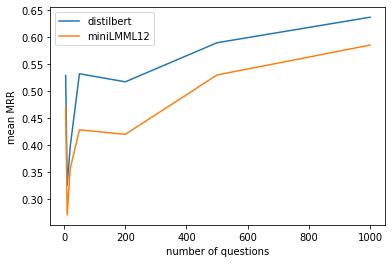

In [28]:
from matplotlib import pyplot as plt

plt.plot(number_of_questions_to_test, MRRs, label="distilbert")
plt.plot(number_of_questions_to_test, MRRs_miniLMML12, label="miniLMML12")

plt.xlabel("number of questions")
plt.ylabel("mean MRR")

plt.legend()
plt.show()

In [29]:
df_unique_context = df.drop_duplicates(subset=['context'])
df_unique_context

,title,context,question,encode-miniLMML12,encode-distilbert,question-miniLMML12,question-distilbert
0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,"[-0.014112590812146664, 0.04530408978462219, -...","[0.02346816658973694, -0.021436410024762154, 0...","[0.04350057616829872, -0.0021584501955658197, ...","[-0.03314473479986191, -0.04211437329649925, 0..."
9,Normans,"The Norman dynasty had a major political, cult...",Who was the duke in the battle of Hastings?,"[-0.03266799822449684, 0.051499467343091965, -...","[-0.0030391330365091562, -0.02289517968893051,...","[0.00812420342117548, 0.05871606990695, 0.0580...","[-0.036330562084913254, -0.026018474251031876,..."
17,Normans,"The English name ""Normans"" comes from the Fren...",What is the original meaning of the word Norman?,"[-0.014187667518854141, -1.3138037502358202e-0...","[0.016472309827804565, 0.021069595590233803, 0...","[0.007339480333030224, 0.009790783748030663, 0...","[0.02134949155151844, 0.01611136458814144, -0...."
21,Normans,"In the course of the 10th century, the initial...",When was the Duchy of Normandy founded?,"[-0.009823390282690525, 0.06069493293762207, -...","[0.01437777653336525, -0.04627485200762749, 0....","[-0.018730690702795982, -0.01388996746391058, ...","[-0.00811005849391222, -0.02430654875934124, 0..."
28,Normans,"Before Rollo's arrival, its populations did no...",Who upon arriving gave the original viking set...,"[0.05280990153551102, 0.045769110321998596, -0...","[0.012998299673199654, -0.02163497544825077, 0...","[0.01598675549030304, 0.056634124368429184, 0....","[-0.007162353023886681, 0.07129977643489838, -..."
...,...,...,...,...,...,...,...
9995,MXR North West,MXR North West was a regional commercial digit...,,"[0.02997450716793537, -0.07113267481327057, -0...","[0.009767112322151661, 0.0390683189034462, 0.0...",None,None
9996,Crown Spa Hotel,For other hotels with a similar name see Crown...,,"[0.08735831826925278, -0.020637422800064087, -...","[0.01799948513507843, 0.03426392376422882, 0.0...",None,None
9997,Ukraine national rugby union team,The Ukraine national rugby union team represen...,,"[0.06430972367525101, 0.08653005957603455, -0....","[0.08726081997156143, -0.05258721113204956, -0...",None,None
9998,JDS Kunisaki (LST-4003),JS Kunisaki is a Ōsumi class LST of the Japan ...,,"[0.011348671279847622, -0.06884750723838806, -...","[-0.009464837610721588, -0.07844091206789017, ...",None,None


In [30]:
import hnswlib

hnsw_data = np.array(df_unique_context["encode-distilbert"].to_list())

num_elements, dim = hnsw_data.shape
hnsw_ids = np.arange(num_elements)

In [31]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = dim)

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

# Element insertion (can be called several times):
p.add_items(hnsw_data, hnsw_ids)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

In [32]:
questions = np.array(df["question-distilbert"].dropna().to_list())
questions.shape

(5000, 768)

In [33]:
# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels, distances = p.knn_query(questions, k = 10)

In [34]:
labels

array([[   3,    1,   16, ..., 5166, 5499,   31],
       [  16,    3,    0, ...,   33,   18,   22],
       [   0,    5,    2, ...,    1,   31,    7],
       ...,
       [ 501,  502,  506, ...,  504, 1177,  498],
       [ 506,  502,  498, ...,  497, 5289, 1585],
       [ 506,  496,  502, ...,  503, 4675,  372]], dtype=uint64)

In [35]:
df_unique_context.iloc[[3,1534,3432]]

,title,context,question,encode-miniLMML12,encode-distilbert,question-miniLMML12,question-distilbert
21,Normans,"In the course of the 10th century, the initial...",When was the Duchy of Normandy founded?,"[-0.009823390282690525, 0.06069493293762207, -...","[0.01437777653336525, -0.04627485200762749, 0....","[-0.018730690702795982, -0.01388996746391058, ...","[-0.00811005849391222, -0.02430654875934124, 0..."
6027,Planephones,"Planephones, or planofoni, represent an innova...",,"[-2.1212206775089726e-05, 0.06377863138914108,...","[0.035153187811374664, -0.003805996850132942, ...",None,None
7925,Gaznich,Gaznich is a town in north-west Tajikistan. I...,,"[-0.008506376296281815, 0.017053313553333282, ...","[-0.04841030389070511, -0.022568929940462112, ...",None,None


In [36]:
def get_MRR_with_KNN(num_questions: int = len(df_unique_context), model_name: str = "distilbert", n_neighbours: int = 100) -> float:

    num_questions = min(num_questions, len(df_unique_context))

    questions = np.array(df[f"question-{model_name}"].dropna().to_list())[:num_questions]

    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    labels, distances = p.knn_query(questions, k = n_neighbours)

    MRR = 0
    for i in range(num_questions):
    
        if not i in labels[i]:
            my_q_index = n_neighbours
        else:
            my_q_index = labels[i].tolist().index(i)

        my_q_index += 1 # To avoid division by zero

        MRR += 1 / my_q_index

    return MRR / num_questions

In [37]:
number_of_questions_to_test = [5, 10, 20, 50, 200, 500, 1000]
KNN_MRR_distilbert = [get_MRR_with_KNN(n) for n in number_of_questions_to_test]

In [38]:
KNN_MRR_miniLMML12 = [get_MRR_with_KNN(n, "miniLMML12") for n in number_of_questions_to_test]

In [ ]:
from matplotlib import pyplot as plt

plt.plot(number_of_questions_to_test, KNN_MRR_distilbert, label="distilbert")
plt.plot(number_of_questions_to_test, KNN_MRR_miniLMML12, label="miniLMML12")

plt.xlabel("number of questions")
plt.ylabel("mean MRR")

plt.legend()
plt.show()